# Wine Project

## Context

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are much more normal wines than excellent or poor ones).

This dataset is also available from the UCI machine learning repository, https://archive.ics.uci.edu/ml/datasets/wine+quality , I just shared it to kaggle for convenience. (If I am mistaken and the public license type disallowed me from doing so, I will take this down if requested.)

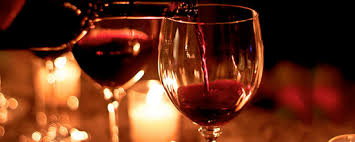

## Content

For more information, read [Cortez et al., 2009].

Input variables (based on physicochemical tests):

1 - fixed acidity 

2 - volatile acidity 

3 - citric acid 

4 - residual sugar 

5 - chlorides 

6 - free sulfur dioxide 

7 - total sulfur dioxide 

8 - density 

9 - pH 

10 - sulphates 

11 - alcohol 

Output variable (based on sensory data): 

12 - quality (score between 0 and 10) 

## Tips

What might be an interesting thing to do, is aside from using regression modelling, is to set an arbitrary cutoff for your dependent variable (wine quality) at e.g. 7 or higher getting classified as 'good/1' and the remainder as 'not good/0'.
This allows you to practice with hyper parameter tuning on e.g. decision tree algorithms looking at the ROC curve and the AUC value.
Without doing any kind of feature engineering or overfitting you should be able to get an AUC of .88 (without even using random forest algorithm)

KNIME is a great tool (GUI) that can be used for this.

1 - File Reader (for csv) to linear correlation node and to interactive histogram for basic EDA.

2- File Reader to 'Rule Engine Node' to turn the 10 point scale to dichtome variable (good wine and rest), the code to put in the rule engine is something like this:

**quality** 
>  quality > 6.5 => "good" 

> ELSE => "bad" 

3- Rule Engine Node output to input of Column Filter node to filter out your original 10point feature (this prevent leaking)

4- Column Filter Node output to input of Partitioning Node (your standard train/tes split, e.g. 75%/25%, choose 'random' or 'stratified')

5- Partitioning Node train data split output to input of Train data split to input Decision Tree Learner node and 

6- Partitioning Node test data split output to input Decision Tree predictor Node

7- Decision Tree learner Node output to input Decision Tree Node input

8- Decision Tree output to input ROC Node.. (here you can evaluate your model base on AUC value)
Inspiration

Use machine learning to determine which physiochemical properties make a wine 'good'!

Acknowledgements

This dataset is also available from the UCI machine learning repository, https://archive.ics.uci.edu/ml/datasets/wine+quality , I just shared it to kaggle for convenience. (I am mistaken and the public license type disallowed me from doing so, I will take this down at first request. I am not the owner of this dataset.

Please include this citation if you plan to use this database: P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

Relevant publication

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. 
In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

# Import Library

In [1]:
!pip install -U scikit-learn
!pip install imblearn

Requirement already up-to-date: scikit-learn in /Users/HBJ/opt/anaconda3/lib/python3.7/site-packages (0.23.2)


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# Loading dataset

In [3]:
df = pd.read_csv('winequality-red.csv')

In [4]:
# Let's check how the data is distributed
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## Exploratory data analysis

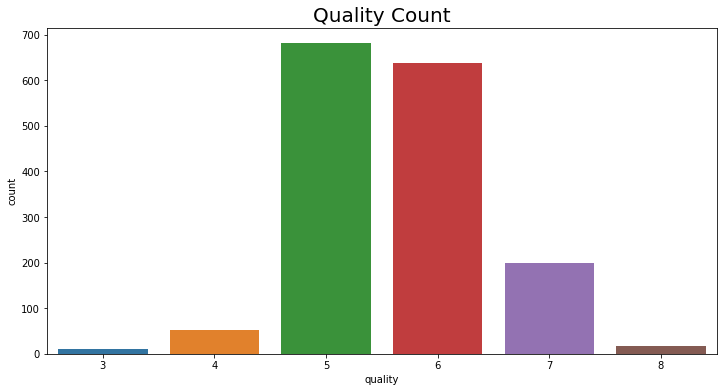

In [7]:
plt.figure(figsize=(12,6))
sns.countplot(df.quality)
plt.title("Quality Count",size=20)
plt.show()

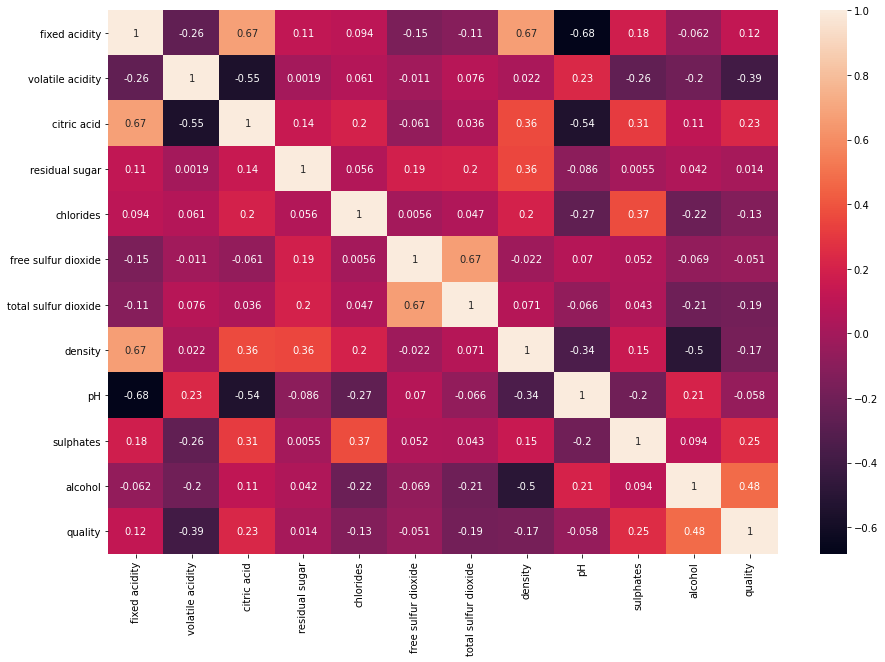

In [8]:
# Observing the relationship between the columns.
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)

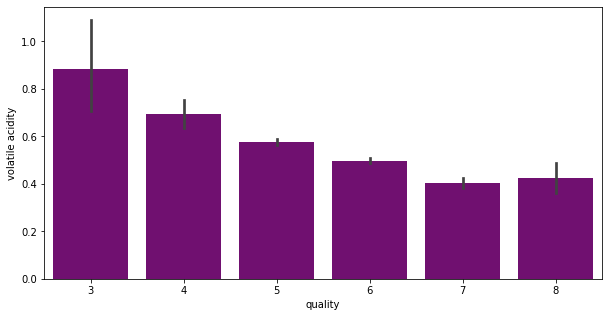

In [9]:
plt.figure(figsize=(10,5))
sns.barplot(x='quality',y='volatile acidity',data=df,color = 'purple')
plt.show()

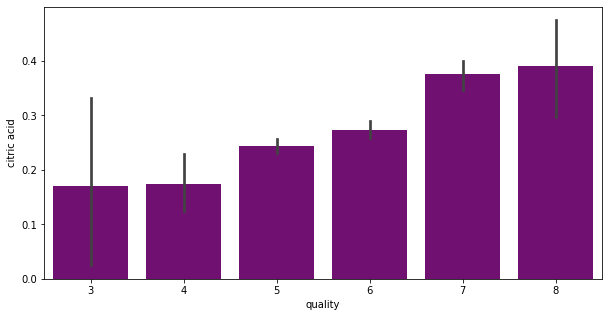

In [10]:
plt.figure(figsize=(10,5))
sns.barplot(x='quality',y='citric acid',data=df,color = 'purple')
plt.show()

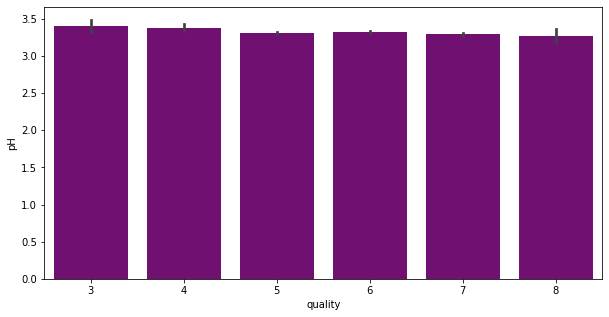

In [11]:
plt.figure(figsize=(10,5))
sns.barplot(x='quality',y='pH',data=df,color = 'purple')
plt.show()

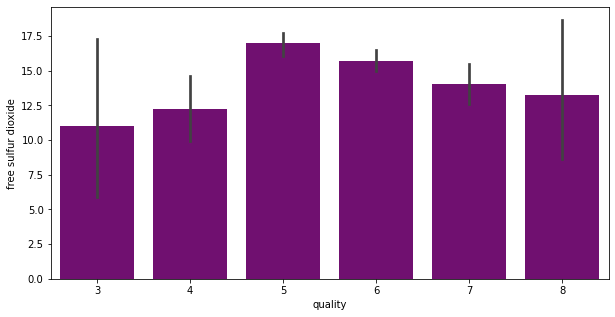

In [12]:
plt.figure(figsize=(10,5))
sns.barplot(x='quality',y='free sulfur dioxide',data=df,color = 'purple')
plt.show()

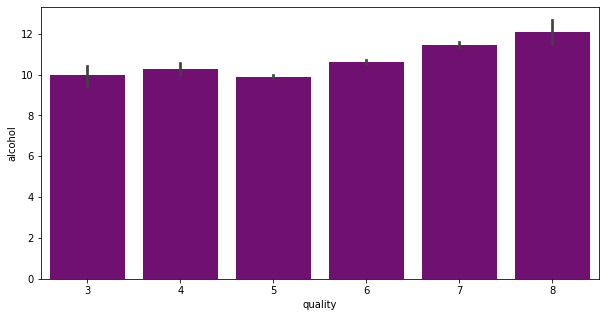

In [13]:
plt.figure(figsize=(10,5))
sns.barplot(x='quality',y='alcohol',data=df,color = 'purple')
plt.show()

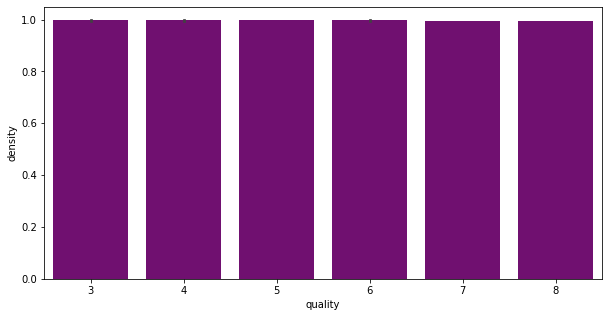

In [14]:
plt.figure(figsize=(10,5))
sns.barplot(x='quality',y='density',data=df,color = 'purple')
plt.show()

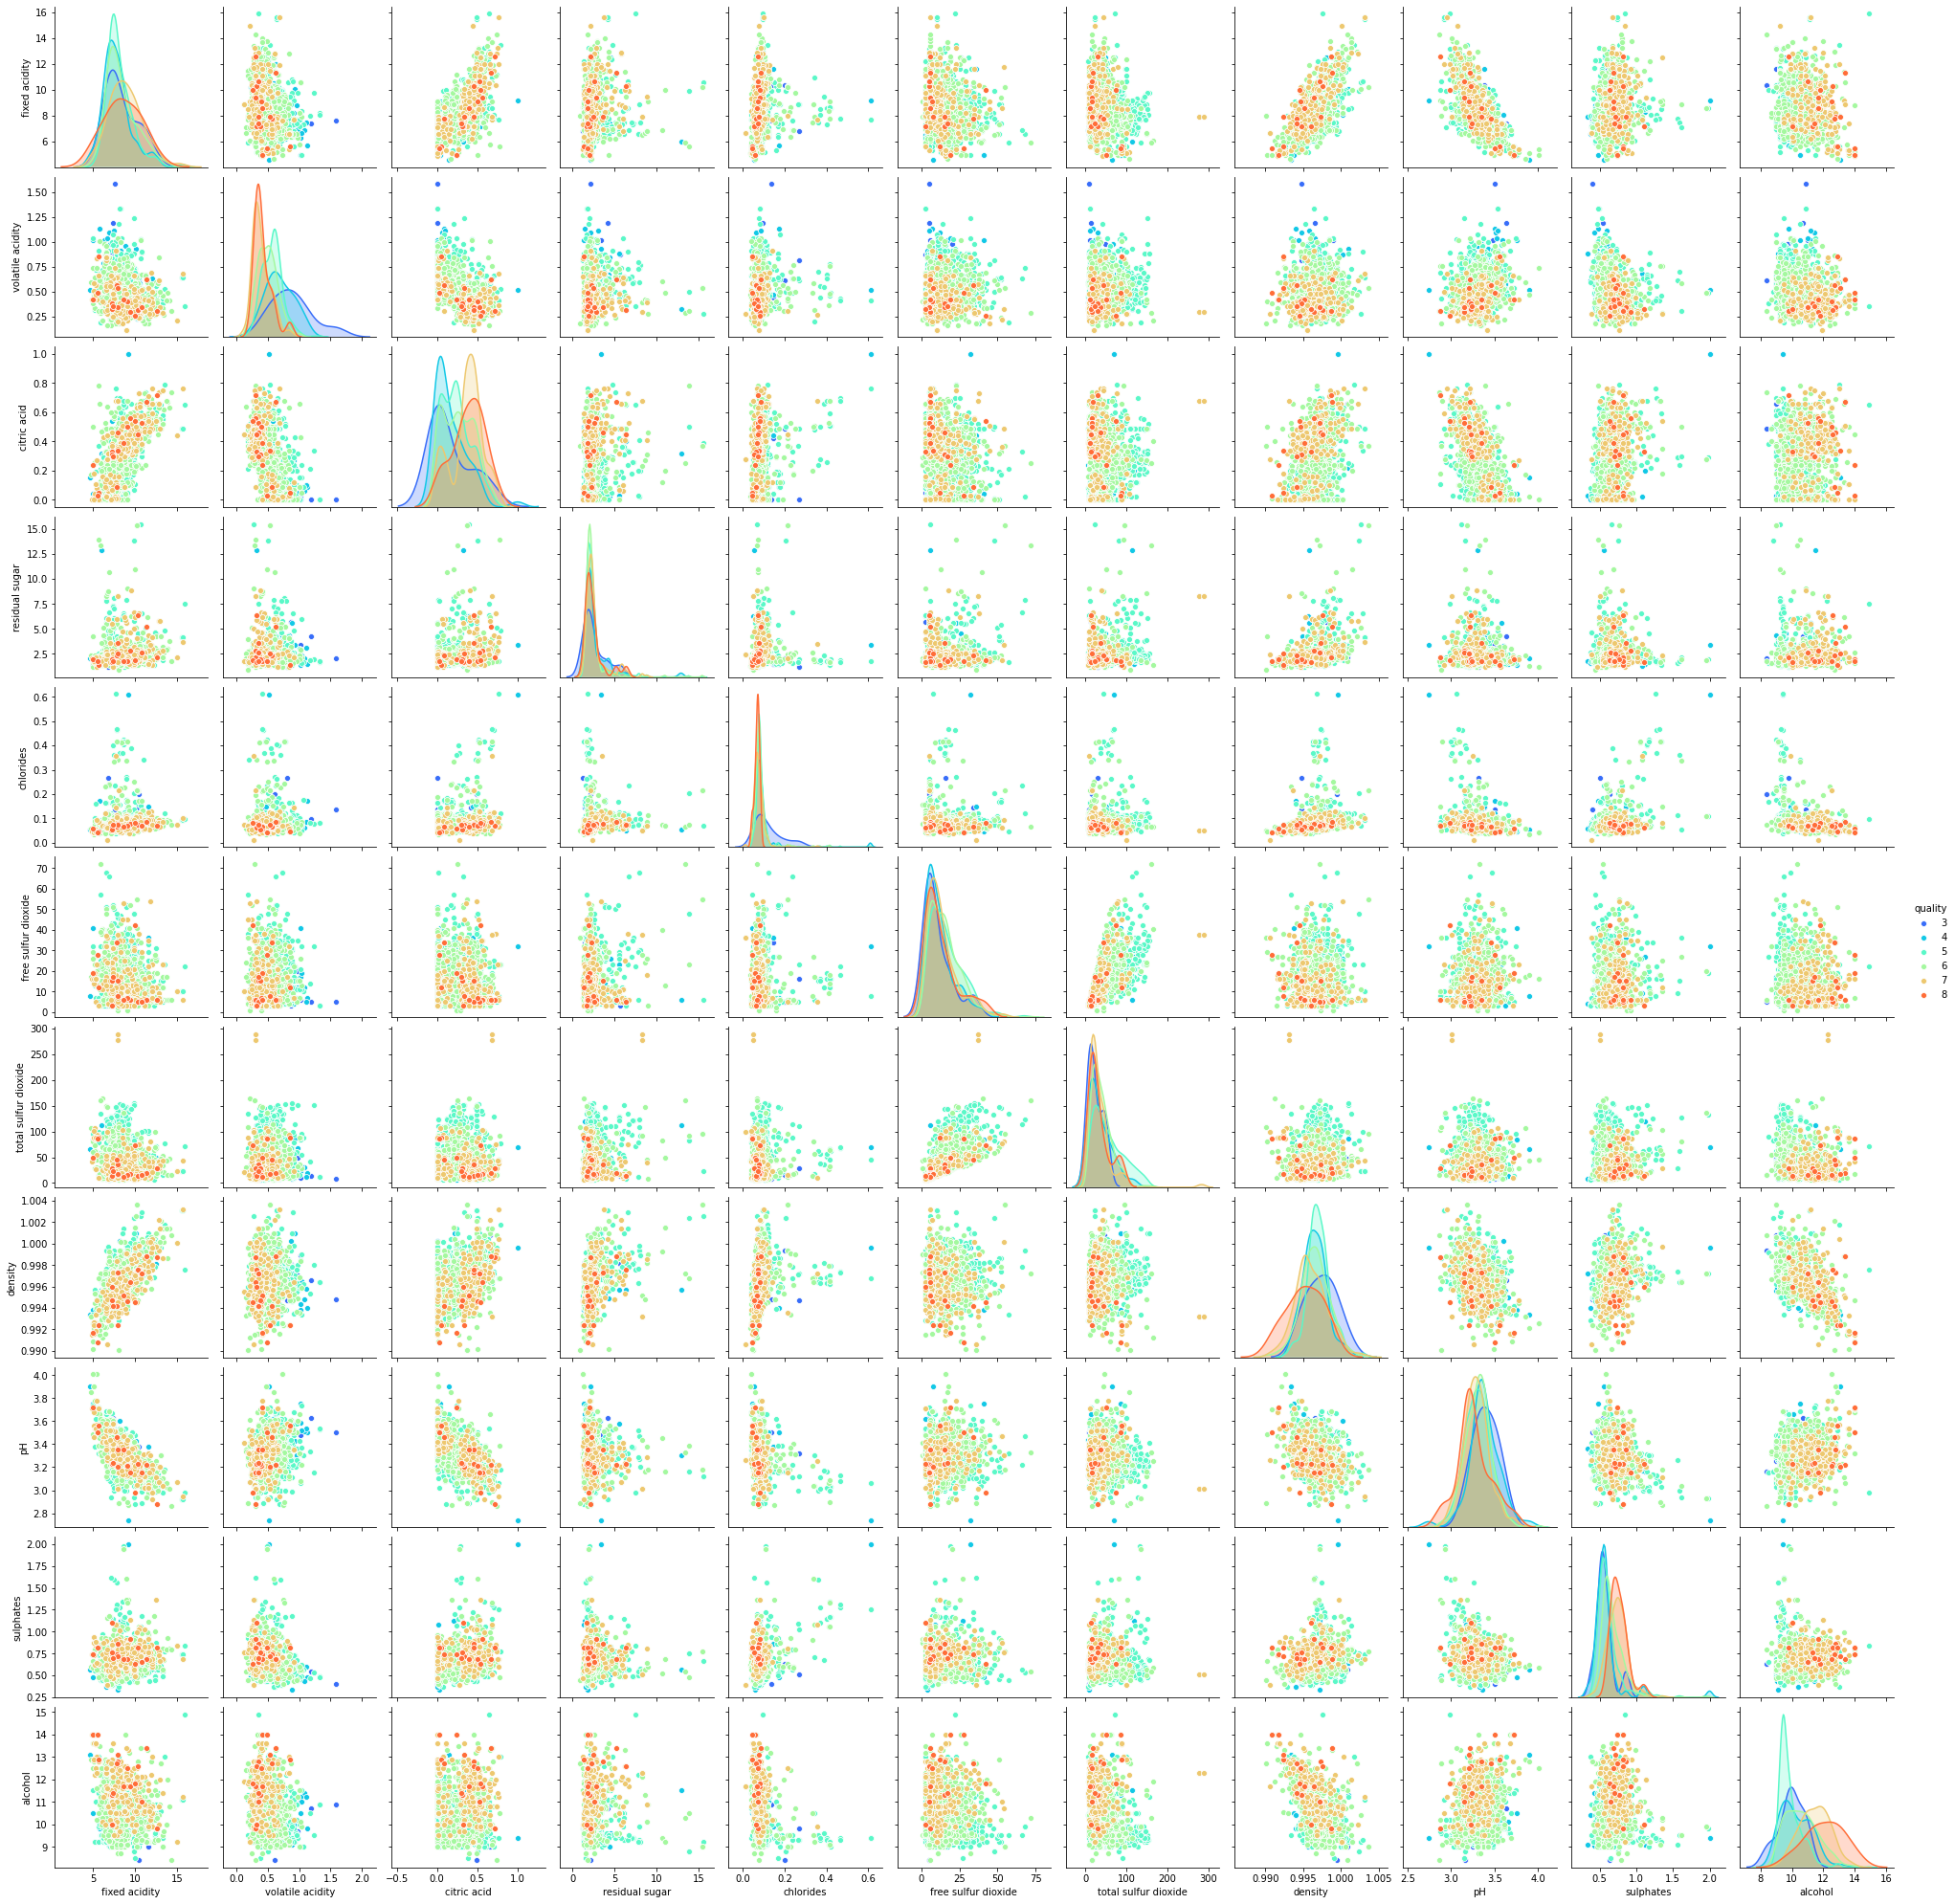

In [15]:
sns.pairplot(data=df,hue='quality',palette='rainbow')

# Processing Data

In [16]:
df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [17]:
def quality(item):
    if item > 6.5:
        return 1
    else:
        return 0

In [18]:
df['quality'] = df['quality'].apply(lambda x: quality(x))


 Count Wine Data for quality. 
 0="bad" 
 1="good"  

0    1382
1     217
Name: quality, dtype: int64


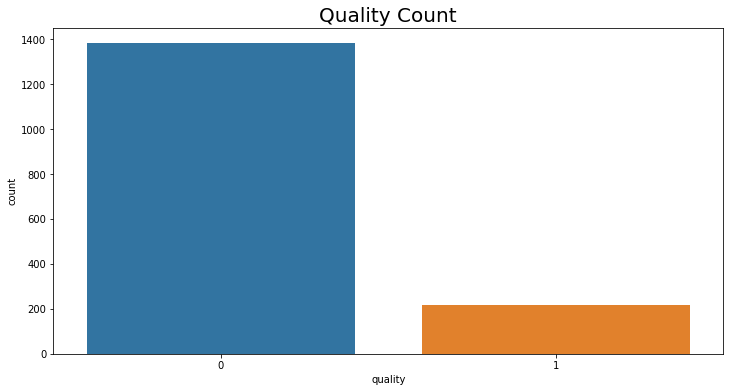

In [19]:
print('\n Count Wine Data for quality. \n 0="bad" \n 1="good"  \n')
print(df['quality'].value_counts())
plt.figure(figsize=(12,6))
sns.countplot(df.quality)
plt.title("Quality Count",size=20)
plt.show()

We can see that the data is unbalanced,
this is generally bad for our project, however, I will apply a Machine Leraning algorithm to our Dataset as it is now, then I will apply Undersampling and on top of it I will apply another Machine Learning algorithm, and finally, I will apply Oversampling and another algorithm of Machine Learning in this.

Finally, I would like to conclude for which techniques the performance was better.

# At first:
## The Original Dataset

In [20]:
# Using Decision Tree
x = df.drop('quality',axis=1)
y = df['quality']
x_train,x_test, y_train,y_test = train_test_split(x,y,test_size=0.3) # split
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

In [21]:
tree = DecisionTreeClassifier()
tree.fit(x_train,y_train) # train

DecisionTreeClassifier()

In [22]:
predict = tree.predict(x_test)
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

[[380  41]
 [ 31  28]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       421
           1       0.41      0.47      0.44        59

    accuracy                           0.85       480
   macro avg       0.67      0.69      0.68       480
weighted avg       0.86      0.85      0.85       480



In [23]:
# Using Random Forest
forest = RandomForestClassifier()
forest.fit(x_train,y_train) # train

RandomForestClassifier()

In [24]:
predict = forest.predict(x_test)
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

[[411  10]
 [ 32  27]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       421
           1       0.73      0.46      0.56        59

    accuracy                           0.91       480
   macro avg       0.83      0.72      0.76       480
weighted avg       0.90      0.91      0.90       480



In [25]:
# Using Logistic Regression
lgr = LogisticRegression()
lgr.fit(x_train,y_train) # train

LogisticRegression()

In [26]:
predict = lgr.predict(x_test)
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

[[404  17]
 [ 35  24]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       421
           1       0.59      0.41      0.48        59

    accuracy                           0.89       480
   macro avg       0.75      0.68      0.71       480
weighted avg       0.88      0.89      0.88       480



**I can improve my project, usin the methody Supoort Vector Machine (SVC)**

In [27]:
svc = SVC()
svc.fit(x_train,y_train)

SVC()

In [28]:
predict = svc.predict(x_test)
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

[[412   9]
 [ 36  23]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       421
           1       0.72      0.39      0.51        59

    accuracy                           0.91       480
   macro avg       0.82      0.68      0.73       480
weighted avg       0.89      0.91      0.89       480



In [29]:
#Finding best parameters for our SVC model
param = {
    'C': [0.1,0.8,0.9,1,1.1,1.2,1.3,1.4],
    'kernel':['linear', 'rbf'],
    'gamma' :[0.1,0.8,0.9,1,1.1,1.2,1.3,1.4]
}
grid_svc = GridSearchCV(svc, param_grid=param, scoring='recall', cv=10)

In [30]:
grid_svc.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
                         'gamma': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
                         'kernel': ['linear', 'rbf']},
             scoring='recall')

In [31]:
#Best parameters for our svc model
grid_svc.best_params_

{'C': 1.4, 'gamma': 0.8, 'kernel': 'rbf'}

In [32]:
svc2 = SVC(C = 1, gamma =  0.1, kernel= 'rbf')
svc2.fit(x_train,y_train)

SVC(C=1, gamma=0.1)

In [33]:
predict = svc2.predict(x_test)
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

[[413   8]
 [ 35  24]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       421
           1       0.75      0.41      0.53        59

    accuracy                           0.91       480
   macro avg       0.84      0.69      0.74       480
weighted avg       0.90      0.91      0.90       480



In [34]:
#Now lets try to do some evaluation for random forest model using cross validation.
forest_eval = cross_val_score(estimator = forest, X = x_train, y = y_train, cv = 10)
forest_eval.mean()

0.9052686615186616

Despite trying to improve The Random Forest using cross validation, the accuracy has not changed, and although the original data set is unbalanced, the accuracy has been greater than 90%.

# Second one:
## Using the Undersampling

In [35]:
under = NearMiss()
x = df.drop('quality',axis=1)
y = df['quality']
x,y = under.fit_sample(x,y)
x_train,x_test, y_train,y_test = train_test_split(x,y,test_size=0.3) # split

Good wine count: 217
Bad wine count: 217


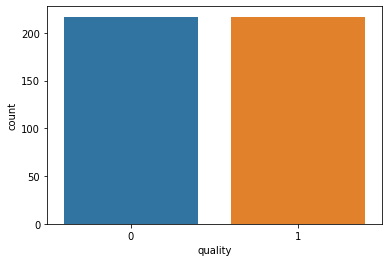

In [36]:
print("Good wine count: {}".format(int(len(y)/2)))
print("Bad wine count: {}".format(int(len(y)/2)))
sns.countplot(x=y)
plt.show()

In [37]:
# Using Random Forest
forest = RandomForestClassifier()
forest.fit(x_train,y_train) # train

RandomForestClassifier()

In [38]:
predict = forest.predict(x_test)
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

[[55 18]
 [13 45]]
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        73
           1       0.71      0.78      0.74        58

    accuracy                           0.76       131
   macro avg       0.76      0.76      0.76       131
weighted avg       0.77      0.76      0.76       131



# Finally:
## Using the Oversampling

In [39]:
over = SMOTE(random_state=482)
x = df.drop('quality',axis=1)
y = df['quality']
x,y = over.fit_sample(x,y)
x_train,x_test, y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=102) # split

Good wine count: 1382
Bad wine count: 1382


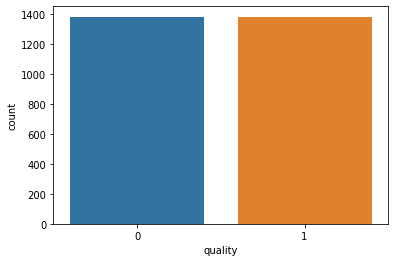

In [40]:
print("Good wine count: {}".format(int(len(y)/2)))
print("Bad wine count: {}".format(int(len(y)/2)))
sns.countplot(x=y)
plt.show()

In [41]:
# Using Random Forest
forest = RandomForestClassifier(random_state=482)
forest.fit(x_train,y_train) # train

RandomForestClassifier(random_state=482)

In [42]:
predict = forest.predict(x_test)
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

[[377  34]
 [ 20 399]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       411
           1       0.92      0.95      0.94       419

    accuracy                           0.93       830
   macro avg       0.94      0.93      0.93       830
weighted avg       0.94      0.93      0.93       830



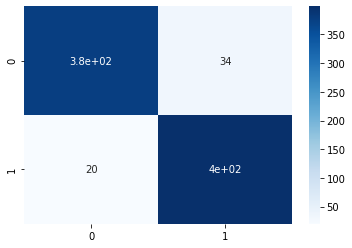

In [43]:
cm = confusion_matrix(y_test,predict)
sns.heatmap(cm,cmap='Blues',annot=True)

# Conclusion

When using the original dataset, the result was even greater than expected when looking at the accuracy, however, this is not the only parameter to be observed, as the recall remained much lower. With the Undersampling technique there was no change for more, on the contrary, there was a decrease in accuracy, but a significant increase in recall, obtaining an increase of almost 100% in relation to the previous value.

Finally, the most outstanding technique for this dataset is Oversampling, with which we can observe a significant increase in accuracy, not to mention Recall's 94%.
Without a doubt the best set of techniques.